This notebook is for generating miscilaneous plots so that my other notebooks don't get too messy

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F
from os.path import exists
from tqdm import tqdm
from sklearn.decomposition import PCA
import numpy as np
from scipy.stats import norm, t
import time, math, sys, os
import pickle as pkl
from IPython.utils import io
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.markers import MarkerStyle
plt.rcParams['figure.facecolor'] = 'white'
from classy import Class
import getdist
from getdist import plots, MCSamples

#from pk_tools import pk_tools
sys.path.insert(1, '/home/joeadamo/Research/CovNet')
#sys.path.insert(1, "/users/JoeyA/Research/CovNet")
import src as CovNet
import src.CovaPT as CovaPT

base_dir = "/home/joeadamo/Research/CovNet/"

In [2]:
training_dir = "/home/joeadamo/Research/CovNet/Data/Training-Set-HighZ-NGC/"
test_data = CovNet.MatrixDataset(training_dir, "testing", 1., train_gaussian_only=False)

### Loss with respect to size of training set

658727.5


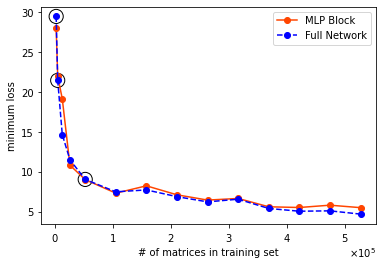

In [3]:
data_MLP = torch.load(base_dir+"emulators/ngc_z3/MLP/output_data_old.dat", map_location=torch.device("cpu"))
data_T = torch.load(base_dir+"emulators/ngc_z3/MLP-T/output_data.dat", map_location=torch.device("cpu"))
data_T_small = torch.load(base_dir+"emulators/ngc_z3/MLP-T-smaller/output_data.dat", map_location=torch.device("cpu"))
data_T = torch.cat([data_T_small[0:4], data_T], 0)

N = 526982
print(N / 0.8)
sizes_small = torch.Tensor([0.005, 0.01, 0.025, 0.05])
sizes = torch.Tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
sizes = torch.cat([sizes_small, sizes])

loss_data = data_MLP[0:10]
time_data = data_MLP[10:]
min_data = torch.min(loss_data, axis=1)
# the last few entries had a non-optimal batch size, so manually add in more recent, better runs
min_data[0][-1] = 5.74
min_data[0][-2] = 5.57
min_data[0][-3] = 5.53

# plt.plot(sizes * N, min_data[0], ls="--", marker="o")
# #plt.scatter(N, 5.79, marker="o", c="red")
# plt.xlabel("# of matrices in training set")
# plt.ylabel("minimum loss")

MLP_loss_data = torch.min(data_T[0:14][:,:,0], axis=1)[0]
T_loss_data = torch.min(data_T[0:14][:,:,1], axis=1)[0]
T_loss_data[2]=data_T[2,0,1]
idx = [0, 1, 4]

plt.figure()
#plt.plot(sizes * N, min_data[0], ls="--", marker="o")
plt.plot(sizes*N, MLP_loss_data, marker="o", c="orangered", label="MLP Block")
plt.scatter(sizes[idx]*N, T_loss_data[idx], marker="o", s=200, facecolors='none', edgecolors='black')
plt.plot(sizes*N, T_loss_data, ls="--", marker="o", c="blue", label="Full Network")
plt.xlabel("# of matrices in training set")
plt.ylabel("minimum loss")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0), useMathText=True)
#plt.xscale("log")
#plt.ylim(5.5, 9.5)
plt.legend()
plt.savefig("../Plots/datasize.pdf")

## Calculate best-fit shifts in contours from using the emulators

In [4]:
def load_NG_chain(file):

    chain_load = np.genfromtxt(file, names=names)
    chain_load["As"] *= 3.0447

    new_dt = np.dtype(chain_load.dtype.descr + [('h', "<f8")])
    chain_NG = np.zeros(chain_load.shape, dtype=new_dt)
    for name in chain_load.dtype.names:
        chain_NG[name] = chain_load[name]
    chain_NG["h"] = chain_NG["H0"] / 100.
    return chain_NG

montepython_dir = base_dir+"chains/MontePython/"
def load_chains(prefix, burn_in, names):
    
    all_filenames = next(os.walk(montepython_dir+prefix), (None, None, []))[2]  # [] if no file
    chain_files = []
    for i in range(len(all_filenames)):
        if ".txt" in all_filenames[i]:
            if "._" in all_filenames[i][:2]:
                #chain_files.append(all_filenames[i][2:])
                continue
            else:
                chain_files.append(all_filenames[i])
    chain_files.sort()
                
    chain_combined = np.genfromtxt(montepython_dir+prefix+chain_files[0], names=names)
    chain_combined = chain_combined[burn_in[0]:]
    for i in range(1, len(chain_files)):
        if burn_in[i] != -1:
            chain_sub = np.genfromtxt(montepython_dir+prefix+chain_files[i], names=names)
            chain_sub = chain_sub[burn_in[i]:]
            # combine all chains into one big chain
            chain_combined = np.concatenate((chain_combined, chain_sub))
    return chain_combined

In [5]:
# Non-Gaussian test
names=["loglike", "H0", "omch2", "As", "b1", "b2", "bG2", "Om0", "sigma8"]
names_marg=["jump factor?", " loglike", "omch2", "h", "As", "b1", "b2", "bG2", "Omega_m", "H0", "sigma8"]
labels_2 =  ["\omega_{cdm}", "h", "\ln{10^{10}A_s}", "b_1", 'b_2', "b_{G2}", "cs0", "cs2", "\bar{c}", "P_{shot}"]

chain_NG = load_NG_chain("/home/joeadamo/Research/CovNet/Data/Inportance-Set-1/chain_inportance.txt")
chain_MLP = load_chains("simulated-data/vary-MLP/", [16, 17, 27, 14, 27, 9, 9, 20], names_marg)
chain_MLP_T = load_chains("simulated-data/vary-MLP-T/", [28, 20, 24, 23, 27, 12, 22, 21], names_marg)
names.append("h")

#MLP_data = np.loadtxt(base_dir+"chains/MontePython/simulated-data/vary-MLP/vary-MLP.h_info", skiprows=1, usecols=[2,3,4,5,6,7,8,9,10])
#MLP_T_data = np.loadtxt(base_dir+"chains/MontePython/simulated-data/vary-MLP-T/vary-MLP-T.h_info", skiprows=1, usecols=[2,3,4,5,6,7,8,9,10])
#idx_map = [7, 0, 2, 3, 4, 5, 6, 8, 1]
idx_map = [9, 2, 4, 5, 6, 7, 8, 10, 3]

samples = np.zeros((len(chain_NG["H0"]), len(names)))
for i in range(len(chain_NG.dtype.names)):
    samples[:, i] = np.array(chain_NG[chain_NG.dtype.names[i]])
NG_samples = MCSamples(samples=samples, loglikes=chain_NG["loglike"], names = names, labels=names)

samples = np.zeros((len(chain_MLP["H0"]), len(names_marg)))
for i in range(len(chain_MLP.dtype.names)):
    samples[:, i] = np.array(chain_MLP[chain_MLP.dtype.names[i]])
MLP_samples = MCSamples(samples=samples, loglikes=chain_MLP["loglike"], names = names_marg, labels=names_marg)

samples = np.zeros((len(chain_MLP_T["H0"]), len(names_marg)))
for i in range(len(chain_MLP_T.dtype.names)):
    samples[:, i] = np.array(chain_MLP_T[chain_MLP_T.dtype.names[i]])
MLP_T_samples = MCSamples(samples=samples, loglikes=chain_MLP_T["loglike"], names = names_marg, labels=names_marg)

stats_NG = NG_samples.getMargeStats()
stats_MLP = MLP_samples.getMargeStats()
stats_MLP_T = MLP_T_samples.getMargeStats()
avg_shift = np.zeros(2)

print("True chain has  {:0.0f} samples".format(chain_NG.shape[0]))
print("MLP chain has   {:0.0f} samples".format(chain_MLP.shape[0]))
print("MLP-T chain has {:0.0f} samples".format(chain_MLP_T.shape[0]))

for i in range(1, len(names)):
    
    true_bestfit = stats_NG.names[i].mean
    true_sigma = stats_NG.names[i].err
    
    MLP_bestfit = stats_MLP.names[idx_map[i-1]].mean
    MLP_T_bestfit = stats_MLP_T.names[idx_map[i-1]].mean
    
    MLP_shift = (MLP_bestfit - true_bestfit) / true_sigma
    MLP_T_shift = (MLP_T_bestfit - true_bestfit) / true_sigma
    if names[i] != "h": 
        avg_shift = avg_shift + abs(np.array([MLP_shift, MLP_T_shift]))
        print(names[i] + ":\t MLP = {:0.3f} sigma,\t MLP-T = {:0.3f} sigma".format(MLP_shift, MLP_T_shift))
        #print(names[i] + ":\t ${:0.3f}\sigma$ & ${:0.3f}\sigma$ &".format(MLP_shift, MLP_T_shift))
    
avg_shift = avg_shift / (len(names_marg)-2)
print("\naverage\t MLP = {:0.2f} sigma\t MLP-T = {:0.2f} sigma".format(avg_shift[0], avg_shift[1]))

Removed no burn in
Removed no burn in
Removed no burn in


True chain has  72347 samples
MLP chain has   83626 samples
MLP-T chain has 82281 samples
H0:	 MLP = 0.029 sigma,	 MLP-T = -0.046 sigma
omch2:	 MLP = 0.058 sigma,	 MLP-T = 0.040 sigma
As:	 MLP = 0.068 sigma,	 MLP-T = 0.062 sigma
b1:	 MLP = -0.073 sigma,	 MLP-T = -0.055 sigma
b2:	 MLP = 0.037 sigma,	 MLP-T = -0.007 sigma
bG2:	 MLP = 0.024 sigma,	 MLP-T = -0.005 sigma
Om0:	 MLP = 0.044 sigma,	 MLP-T = 0.083 sigma
sigma8:	 MLP = 0.105 sigma,	 MLP-T = 0.081 sigma

average	 MLP = 0.05 sigma	 MLP-T = 0.04 sigma


In [19]:
# Gaussian test
names=["loglike", "H0", "omch2", "As", "b1", "b2", "bG2", "Om0", "sigma8"]
names_marg=["jump factor?", " loglike", "omch2", "h", "As", "b1", "b2", "bG2", "Om0", "H0", "sigma8"]
labels_2 =  ["\omega_{cdm}", "h", "\ln{10^{10}A_s}", "b_1", 'b_2', "b_{G2}", "cs0", "cs2", "\bar{c}", "P_{shot}"]

chain_G = load_chains("simulated-data/vary-no-determinant/",[37, -1, 20, 30, 15, 38, 14, 13], names_marg)
chain_MLP = load_chains("simulated-data/vary-MLP-gaussian/", [8, 15, 19, 28, 25, 14, 14, 27], names_marg)
chain_MLP_T = load_chains("simulated-data/vary-MLP-T-gaussian/", [26, 21, 21, 34, 18, 18, 22, 18], names_marg)
names.append("h")

#MLP_data = np.loadtxt(base_dir+"chains/MontePython/simulated-data/vary-MLP/vary-MLP.h_info", skiprows=1, usecols=[2,3,4,5,6,7,8,9,10])
#MLP_T_data = np.loadtxt(base_dir+"chains/MontePython/simulated-data/vary-MLP-T/vary-MLP-T.h_info", skiprows=1, usecols=[2,3,4,5,6,7,8,9,10])
#idx_map = [7, 0, 2, 3, 4, 5, 6, 8, 1]
idx_map = [9, 2, 4, 5, 6, 7, 8, 10, 3]

samples = np.zeros((len(chain_G["H0"]), len(names_marg)))
for i in range(len(chain_G.dtype.names)):
    samples[:, i] = np.array(chain_G[chain_G.dtype.names[i]])
G_samples = MCSamples(samples=samples, loglikes=chain_G["loglike"], names = names_marg, labels=names_marg)

samples = np.zeros((len(chain_MLP["H0"]), len(names_marg)))
for i in range(len(chain_MLP.dtype.names)):
    samples[:, i] = np.array(chain_MLP[chain_MLP.dtype.names[i]])
MLP_samples = MCSamples(samples=samples, loglikes=chain_MLP["loglike"], names = names_marg, labels=names_marg)

samples = np.zeros((len(chain_MLP_T["H0"]), len(names_marg)))
for i in range(len(chain_MLP_T.dtype.names)):
    samples[:, i] = np.array(chain_MLP_T[chain_MLP_T.dtype.names[i]])
MLP_T_samples = MCSamples(samples=samples, loglikes=chain_MLP_T["loglike"], names = names_marg, labels=names_marg)

stats_G = G_samples.getMargeStats()
stats_MLP = MLP_samples.getMargeStats()
stats_MLP_T = MLP_T_samples.getMargeStats()
avg_shift = np.zeros(2)

print("Best-fit shift values for the Gaussian Test")
print("True chain has  {:0.0f} samples".format(chain_G.shape[0]))
print("MLP chain has   {:0.0f} samples".format(chain_MLP.shape[0]))
print("MLP-T chain has {:0.0f} samples".format(chain_MLP_T.shape[0]))

#print(G_samples.getLikeStats())

for i in range(2, len(names_marg)):
    
    true_bestfit = stats_G.names[i].mean
    #true_lo = stats_NG.names[i].ND_limit_bot[1]
    #true_sigma = abs(true_bestfit - lo)
    true_sigma = G_samples.getMargeStats().names[i].err
    
    MLP_bestfit = stats_MLP.names[i].mean
    MLP_sigma = stats_MLP.names[i].err
    MLP_T_bestfit = stats_MLP_T.names[i].mean
    MLP_T_sigma = stats_MLP_T.names[i].err
    
    #MLP_bestfit = MLP_data[1, idx_map[i-1]]
    #MLP_T_bestfit = MLP_T_data[1, idx_map[i-1]]
    #print(MLP_T_bestfit)
    
    MLP_shift = (MLP_bestfit - true_bestfit) / true_sigma
    MLP_T_shift = (MLP_T_bestfit - true_bestfit) / true_sigma
    MLP_err_shift = 100*abs(MLP_sigma - true_sigma) / true_sigma
    MLP_T_err_shift = 100*abs(MLP_T_sigma - true_sigma) / true_sigma
    if names_marg[i] != "h": 
        avg_shift = avg_shift + abs(np.array([MLP_shift, MLP_T_shift]))
    
        print(names_marg[i] + ":\t MLP = {:0.3f} sigma (error = {:0.2f}%),\t MLP-T = {:0.3f} sigma (error = {:0.2f}%)".format(MLP_shift, MLP_err_shift, MLP_T_shift, MLP_T_err_shift))
        #print(names_marg[i] + ":\t ${:0.3f}\sigma$ & ${:0.3f}\sigma$ &".format(MLP_shift, MLP_T_shift))
    
avg_shift = avg_shift / (len(names_marg)-1)
print("\naverage\t MLP = {:0.2f} sigma\t MLP-T = {:0.2f} sigma".format(avg_shift[0], avg_shift[1]))

Removed no burn in
Removed no burn in
Removed no burn in


Best-fit shift values for the Gaussian Test
True chain has  72417 samples
MLP chain has   82580 samples
MLP-T chain has 82186 samples
omch2:	 MLP = 0.065 sigma (error = 2.09%),	 MLP-T = 0.003 sigma (error = 0.33%)
As:	 MLP = 0.041 sigma (error = 0.72%),	 MLP-T = -0.009 sigma (error = 0.14%)
b1:	 MLP = -0.042 sigma (error = 1.08%),	 MLP-T = 0.013 sigma (error = 0.62%)
b2:	 MLP = 0.057 sigma (error = 0.94%),	 MLP-T = 0.026 sigma (error = 1.32%)
bG2:	 MLP = 0.060 sigma (error = 0.82%),	 MLP-T = 0.026 sigma (error = 0.71%)
Om0:	 MLP = 0.078 sigma (error = 1.61%),	 MLP-T = 0.007 sigma (error = 1.67%)
H0:	 MLP = -0.007 sigma (error = 0.87%),	 MLP-T = -0.007 sigma (error = 1.27%)
sigma8:	 MLP = 0.082 sigma (error = 1.09%),	 MLP-T = -0.007 sigma (error = 0.27%)

average	 MLP = 0.04 sigma	 MLP-T = 0.01 sigma


In [7]:
# shift values for differet training set sizes

names=["loglike", "H0", "omch2", "As", "b1", "b2", "bG2", "Om0", "sigma8"]
names_marg=["jump factor?", " loglike", "omch2", "h", "As", "b1", "b2", "bG2", "Omega_m", "H0", "sigma8"]
labels_2 =  ["\omega_{cdm}", "h", "\ln{10^{10}A_s}", "b_1", 'b_2', "b_{G2}", "cs0", "cs2", "\bar{c}", "P_{shot}"]

chain_0005 = load_chains("simulated-data/vary-MLP-T-0005/", [82, 117, 95, 96, 88, 100, 121, 87], names_marg)
chain_001 = load_chains("simulated-data/vary-MLP-T-001/", [94, 112, 78, 104], names_marg)
chain_01 = load_chains("simulated-data/vary-MLP-T-01/", [17, 36, 31, 14, 23, 26, 24, 18], names_marg)
names.append("h")

#MLP_data = np.loadtxt(base_dir+"chains/MontePython/simulated-data/vary-MLP/vary-MLP.h_info", skiprows=1, usecols=[2,3,4,5,6,7,8,9,10])
#MLP_T_data = np.loadtxt(base_dir+"chains/MontePython/simulated-data/vary-MLP-T/vary-MLP-T.h_info", skiprows=1, usecols=[2,3,4,5,6,7,8,9,10])
#idx_map = [7, 0, 2, 3, 4, 5, 6, 8, 1]
idx_map = [9, 2, 4, 5, 6, 7, 8, 10, 3]

samples = np.zeros((len(chain_0005["H0"]), len(names_marg)))
for i in range(len(chain_0005.dtype.names)):
    samples[:, i] = np.array(chain_0005[chain_0005.dtype.names[i]])
samples_0005 = MCSamples(samples=samples, loglikes=chain_0005["loglike"], names = names_marg, labels=names_marg)

samples = np.zeros((len(chain_001["H0"]), len(names_marg)))
for i in range(len(chain_001.dtype.names)):
    samples[:, i] = np.array(chain_001[chain_001.dtype.names[i]])
samples_001 = MCSamples(samples=samples, loglikes=chain_001["loglike"], names = names_marg, labels=names_marg)

samples = np.zeros((len(chain_01["H0"]), len(names_marg)))
for i in range(len(chain_01.dtype.names)):
    samples[:, i] = np.array(chain_01[chain_01.dtype.names[i]])
samples_01 = MCSamples(samples=samples, loglikes=chain_01["loglike"], names = names_marg, labels=names_marg)

stats_0005 = samples_0005.getMargeStats()
stats_001 = samples_001.getMargeStats()
stats_01 = samples_01.getMargeStats()

print("0005 chain has {:0.0f} samples".format(chain_0005.shape[0]))
print("001 chain has  {:0.0f} samples".format(chain_001.shape[0]))
print("01 chain has   {:0.0f} samples".format(chain_01.shape[0]))
avg_shift = np.zeros(3)

for i in range(1, len(names)):
    
    true_bestfit = stats_NG.names[i].mean
    true_sigma = NG_samples.getMargeStats().names[i].err
    
    bestfit_0005 = stats_0005.names[idx_map[i-1]].mean
    bestfit_001 = stats_001.names[idx_map[i-1]].mean
    bestfit_01 = stats_01.names[idx_map[i-1]].mean
    
    shift_0005 = (bestfit_0005 - true_bestfit) / true_sigma
    shift_001 = (bestfit_001 - true_bestfit) / true_sigma
    shift_01 = (bestfit_01 - true_bestfit) / true_sigma

    avg_shift = avg_shift + abs(np.array([shift_0005, shift_001, shift_01]))
    print(names[i] + ":\t 0005 = {:0.2f} sigma,\t 001 = {:0.2f} sigma,\t 01 = {:0.2f} sigma".format(shift_0005, shift_001, shift_01))
    #print(names[i] + ":\t ${:0.3f}\sigma$ & ${:0.3f}\sigma$ &".format(MLP_shift, MLP_T_shift))
    
avg_shift = avg_shift / (len(names)-1)
print("\naverage\t 0005 = {:0.2f} sigma\t 001 = {:0.2f} sigma\t 01 = {:0.2f} sigma".format(avg_shift[0], avg_shift[1], avg_shift[2]))

Removed no burn in
Removed no burn in
Removed no burn in


0005 chain has 38746 samples
001 chain has  20480 samples
01 chain has   51913 samples
H0:	 0005 = 0.18 sigma,	 001 = -0.07 sigma,	 01 = 0.02 sigma
omch2:	 0005 = -0.03 sigma,	 001 = 0.12 sigma,	 01 = 0.13 sigma
As:	 0005 = 0.46 sigma,	 001 = 0.07 sigma,	 01 = 0.08 sigma
b1:	 0005 = -0.54 sigma,	 001 = -0.05 sigma,	 01 = -0.09 sigma
b2:	 0005 = -0.65 sigma,	 001 = 0.45 sigma,	 01 = 0.12 sigma
bG2:	 0005 = -0.30 sigma,	 001 = 0.35 sigma,	 01 = 0.11 sigma
Om0:	 0005 = -0.19 sigma,	 001 = 0.19 sigma,	 01 = 0.13 sigma
sigma8:	 0005 = 0.42 sigma,	 001 = 0.15 sigma,	 01 = 0.17 sigma
h:	 0005 = 0.18 sigma,	 001 = -0.07 sigma,	 01 = 0.02 sigma

average	 0005 = 0.33 sigma	 001 = 0.17 sigma	 01 = 0.10 sigma


In [8]:
# compare 2 analytic gaussian chains to estimate what the sampling error is

names_marg=["jump factor?", " loglike", "omch2", "h", "As", "b1", "b2", "bG2", "Om0", "H0", "sigma8"]
labels_2 =  ["\omega_{cdm}", "h", "\ln{10^{10}A_s}", "b_1", 'b_2', "b_{G2}", "cs0", "cs2", "\bar{c}", "P_{shot}"]

chain_G_1 = load_chains("simulated-data/vary-no-determinant/",[37, -1, 20, 30, 15, 38, 14, 13], names_marg)
chain_G_2 = load_chains("simulated-data/smaller-chains/vary-no-determinant-old/", [190, 205, 195, 192], names_marg)
names.append("h")

samples1 = np.zeros((len(chain_G_1["H0"]), len(names_marg)))
samples2 = np.zeros((len(chain_G_2["H0"]), len(names_marg)))
for i in range(len(chain_G.dtype.names)):
    samples1[:, i] = np.array(chain_G_1[chain_G_1.dtype.names[i]])
    samples2[:, i] = np.array(chain_G_2[chain_G_2.dtype.names[i]])
G_samples_1 = MCSamples(samples=samples1, loglikes=chain_G_1["loglike"], names = names_marg, labels=names_marg)
G_samples_2 = MCSamples(samples=samples2, loglikes=chain_G_2["loglike"], names = names_marg, labels=names_marg)

stats_G_1 = G_samples_1.getMargeStats()
stats_G_2 = G_samples_2.getMargeStats()
avg_shift = 0

print("chain 1 has  {:0.0f} samples".format(chain_G_1.shape[0]))
print("chain 2 has  {:0.0f} samples".format(chain_G_2.shape[0]))

#print(G_samples.getLikeStats())

for i in range(2, len(names_marg)):
    
    true_bestfit = stats_G_1.names[i].mean
    true_sigma = G_samples_1.getMargeStats().names[i].err
    
    ref_bestfit = stats_G_2.names[i].mean
    ref_sigma = G_samples_2.getMargeStats().names[i].err
    
    shift = (ref_bestfit - true_bestfit) / true_sigma
    err_shift = 100*abs(ref_sigma - true_sigma) / true_sigma
    if names_marg[i] != "h": avg_shift = avg_shift + abs(shift)
    
    print(names_marg[i] + ":\t shift = {:0.3f} sigma\t error = {:0.2f}%".format(shift, err_shift))
    #print(true_bestfit, MLP_bestfit)
    
avg_shift = avg_shift / (len(names_marg)-2)
print("\naverage = {:0.2f} sigma".format(avg_shift))

Removed no burn in
Removed no burn in
chain 1 has  72417 samples
chain 2 has  19891 samples
omch2:	 shift = -0.006 sigma	 error = 1.27%
h:	 shift = -0.016 sigma	 error = 0.27%
As:	 shift = 0.001 sigma	 error = 0.19%
b1:	 shift = 0.010 sigma	 error = 0.16%
b2:	 shift = 0.030 sigma	 error = 0.08%
bG2:	 shift = 0.001 sigma	 error = 0.30%
Om0:	 shift = 0.006 sigma	 error = 1.58%
H0:	 shift = -0.016 sigma	 error = 0.27%
sigma8:	 shift = -0.004 sigma	 error = 2.12%

average = 0.01 sigma


## Quantify the density of points in the contours we're emulating

In [13]:
training_dir = base_dir+"/Data/Training-Set-HighZ-NGC/"
train_data = CovNet.MatrixDataset(training_dir, "training-small", 1., train_gaussian_only=False)

In [24]:
chain_G = load_chains("simulated-data/vary-no-determinant/",[37, -1, 20, 30, 15, 38, 14, 13], names_marg)

min_data_G = np.array([np.amin(chain_G["H0"]),
                      np.amin(chain_G["omch2"]),
                      np.amin(chain_G["As"]) / 3.0446,
                      np.amin(chain_G["b1"]),
                      np.amin(chain_G["b2"]),
                      np.amin(chain_G["bG2"])])

max_data_G = np.array([np.amax(chain_G["H0"]),
                      np.amax(chain_G["omch2"]),
                      np.amax(chain_G["As"]) / 3.0446,
                      np.amax(chain_G["b1"]),
                      np.amax(chain_G["b2"]),
                      np.amax(chain_G["bG2"])])

min_data_NG = np.array([np.amin(chain_NG["H0"]),
                      np.amin(chain_NG["omch2"]),
                      np.amin(chain_NG["As"]) / 3.0446,
                      np.amin(chain_NG["b1"]),
                      np.amin(chain_NG["b2"]),
                      np.amin(chain_NG["bG2"])])

max_data_NG = np.array([np.amax(chain_NG["H0"]),
                      np.amax(chain_NG["omch2"]),
                      np.amax(chain_NG["As"]) / 3.0446,
                      np.amax(chain_NG["b1"]),
                      np.amax(chain_NG["b2"]),
                      np.amax(chain_NG["bG2"])])

ratio = (max_data_NG - min_data_NG) / (max_data_G - min_data_G)
V_ratio = 1.
for i in range(len(ratio)):
    V_ratio *= ratio[i]
print(V_ratio)
num_posdef_G, num_posdef_NG = 0, 0
params_posdef_G, params_posdef_NG = np.array([0,0,0,0,0,0]), np.array([0,0,0,0,0,0])

print(min_data_G)

for i in tqdm(range(len(train_data))):
    params = train_data[i][0].detach().numpy()
    
    if np.all(params > min_data_G) and np.all(params < max_data_G):
        num_posdef_G += 1
        params_posdef_G = np.vstack((params_posdef_G, params))
    if np.all(params > min_data_NG) and np.all(params < max_data_NG):
        num_posdef_NG += 1
        params_posdef_NG = np.vstack((params_posdef_NG, params))

params_posdef_G = params_posdef_G[1:,:]
params_posdef_NG = params_posdef_NG[1:,:]
       
print("{:0.0f} matrices in inportance region are positive definite".format(num_posdef_NG))
print("{:0.0f} matrices in Gaussian chain are positive definite".format(num_posdef_G))

0.9700749325186397
[61.25357     0.07928165  0.82097221  1.332469   -2.151217   -0.9194794 ]


100%|█████████████████████████████████| 52698/52698 [00:00<00:00, 110688.50it/s]

148 matrices in inportance region are positive definite
152 matrices in Gaussian chain are positive definite


(0.07928165, 0.1704518)

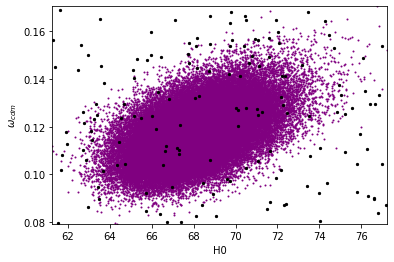

In [21]:
dim1 = 0; dim2 = 1
name1 = "H0"; name2 = "omch2"
plt.scatter(chain_G[name1], chain_G[name2], s=1, c="purple")
#plt.scatter(params_in_range[:,dim1], params_in_range[:,dim2], s=5, label="in training set")
plt.scatter(params_posdef_G[:,dim1], params_posdef_G[:,dim2], c="black", s=5, label="positive definite")
plt.xlabel("H0")
plt.ylabel(r"$\omega_{cdm}$")
plt.xlim(np.amin(chain_G[name1]), np.amax(chain_G[name1]))
plt.ylim(np.amin(chain_G[name2]), np.amax(chain_G[name2]))

## Attempt to recreate a version of Yosuke's plot  

from https://arxiv.org/pdf/2308.08593.pdf figure 1

[67.77    0.1184  1.      2.      0.      0.    ]
avg error per element (MLP)   = 3.161%
avg error per element (MLP-T) = 2.734%
[0.025 0.105 0.205 0.245]


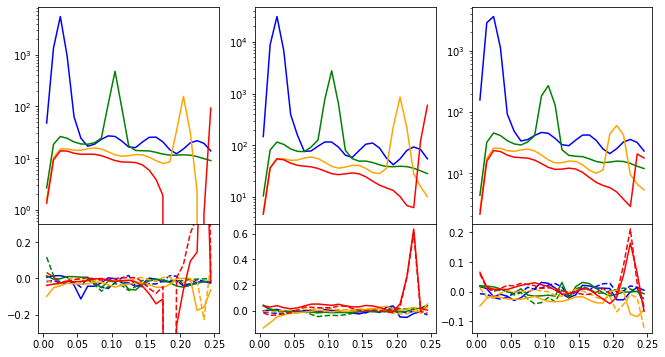

In [6]:
# load in "true" matrix
data = np.load("/home/joeadamo/Research/Software/Montepython/data/BOSS_DR12/Updated/Cov_Fid.npz")

C_True = data["C_G"] + data["C_NG"]
params = data["params"][:6]
print(params)

# load in the neural networks
num_blocks=5
patch_size=torch.Tensor([17,5]).int()
num_heads=5
Cov_Emulator_T = CovNet.Emulator.CovNet("/home/joeadamo/Research/CovNet/emulators/ngc_z3/MLP-T/", 50, "MLP-T", num_blocks=num_blocks, patch_size=patch_size, num_heads=num_heads)
Cov_Emulator_MLP = CovNet.Emulator.CovNet("/home/joeadamo/Research/CovNet/emulators/ngc_z3/MLP/", 50, "MLP")

C_MLP = Cov_Emulator_MLP.get_covariance_matrix(params)
C_T = Cov_Emulator_T.get_covariance_matrix(params)

error_MLP = np.mean(abs((C_MLP / C_True) - 1))
error_T = np.mean(abs((C_T / C_True) - 1))

print("avg error per element (MLP)   = {:0.3f}%".format(100*error_MLP))
print("avg error per element (MLP-T) = {:0.3f}%".format(100*error_T))

k2 = np.linspace(0.005, 0.245, 25)
k1_idx = [2, 10, 20, 24]
print(k2[k1_idx])
c = ["blue", "green", "orange", "red"]

fig, axs = plt.subplots(2, 3, figsize=(11, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

for i in range(len(k1_idx)):

    idx = k1_idx[i]
    axs[0, 0].plot(k2, k2 * k2[idx] * C_True[:25, :25][:, idx], c=c[i])
    axs[0, 1].plot(k2, k2 * k2[idx] * C_True[25:, 25:][:, idx], c=c[i])
    axs[0, 2].plot(k2, k2 * k2[idx] * C_True[:25, 25:][:, idx], c=c[i])

    
    axs[1,0].plot(k2, (C_MLP[:25, :25][:,idx] / C_True[:25, :25][:, idx]) - 1, c=c[i])
    axs[1,1].plot(k2, (C_MLP[25:, 25:][:,idx] / C_True[25:, 25:][:, idx]) - 1, c=c[i])
    axs[1,2].plot(k2, (C_MLP[:25, 25:][:,idx] / C_True[:25, 25:][:, idx]) - 1, c=c[i])

    axs[1,0].plot(k2, (C_T[:25, :25][:,idx] / C_True[:25, :25][:, idx]) - 1, ls="--", c=c[i])
    axs[1,1].plot(k2, (C_T[25:, 25:][:,idx] / C_True[25:, 25:][:, idx]) - 1, ls="--", c=c[i])
    axs[1,2].plot(k2, (C_T[:25, 25:][:,idx] / C_True[:25, 25:][:, idx]) - 1, ls="--", c=c[i])

axs[0,0].set_yscale("log")
axs[0,1].set_yscale("log")
axs[0,2].set_yscale("log")
axs[1,0].set_ylim(-0.3, 0.3)
plt.subplots_adjust(hspace=0)

## Display a few examples of emulated covariance matrices

[67.77    0.1184  1.      2.      0.      0.    ]
2.028, 2.077


/tmp/ipykernel_76545/3261848657.py:31: UserWarning: Using a target size (torch.Size([1, 50, 50])) that is different to the input size (torch.Size([50, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_1 = F.l1_loss(C_fid_raw, C_MLP_raw, reduction="sum")
/tmp/ipykernel_76545/3261848657.py:32: UserWarning: Using a target size (torch.Size([1, 50, 50])) that is different to the input size (torch.Size([50, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_2 = F.l1_loss(C_fid_raw, C_T_raw, reduction="sum")


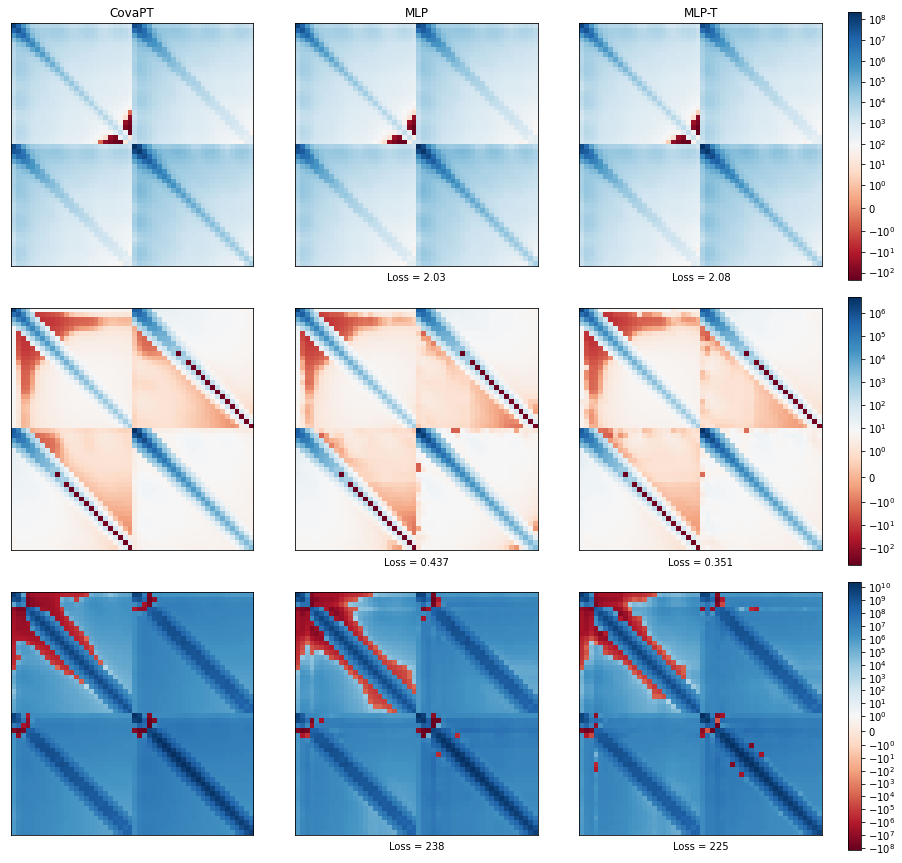

In [5]:
data = np.load("/home/joeadamo/Research/Software/Montepython/data/BOSS_DR12/Updated/Cov_Fid.npz")
C_fid = data["C_G"] + data["C_NG"]
params_fid = data["params"][:6]
print(params_fid)

idx_random = np.random.randint(len(test_data))
idx_good = 0
idx_bad = 54344

#params_random = test_data[idx_random][0].detach().numpy()
#C_fid = test_data.get_full_matrix(idx_random)
C_MLP_fid = Cov_Emulator_MLP.get_covariance_matrix(params_fid)
C_T_fid = Cov_Emulator_T.get_covariance_matrix(params_fid)

params_good = test_data[idx_good][0].detach().numpy()
C_actual_good = test_data.get_full_matrix(idx_good)
C_MLP_good = Cov_Emulator_MLP.get_covariance_matrix(params_good)
C_T_good = Cov_Emulator_T.get_covariance_matrix(params_good)

params_bad = test_data[idx_bad][0].detach().numpy()
C_actual_bad = test_data.get_full_matrix(idx_bad)
C_MLP_bad = Cov_Emulator_MLP.get_covariance_matrix(params_bad)
C_T_bad = Cov_Emulator_T.get_covariance_matrix(params_bad)

C_MLP_raw = Cov_Emulator_MLP.get_covariance_matrix(params_fid, raw=True)
C_T_raw = Cov_Emulator_T.get_covariance_matrix(params_fid, raw=True)
C_fid_raw = torch.from_numpy(np.linalg.cholesky(C_fid)).to(torch.float32)
C_fid_raw = CovNet.symmetric_log(C_fid_raw, 5.91572, 4.62748)
loss_1 = F.l1_loss(C_fid_raw, C_MLP_raw, reduction="sum")
loss_2 = F.l1_loss(C_fid_raw, C_T_raw, reduction="sum")
print("{:0.3f}, {:0.3f}".format(loss_1, loss_2))

fig, axs = plt.subplots(3, 3, figsize=(12, 12))
plt.tight_layout()
axs[0,0].set_title("CovaPT")
mat1 = axs[0,0].imshow(C_fid, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_fid), vmax=np.amax(C_fid)))
axs[0,0].set_xticks([]); axs[0,0].set_yticks([])
axs[0,1].set_title("MLP")
axs[0,1].imshow(C_MLP_fid, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_fid), vmax=np.amax(C_fid)))
axs[0,1].set_xticks([]); axs[0,1].set_yticks([])
axs[0,2].set_title("MLP-T")
axs[0,2].imshow(C_T_fid, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_fid), vmax=np.amax(C_fid)))
axs[0,2].set_xticks([]); axs[0,2].set_yticks([])
axs[0,1].set_xlabel("Loss = 2.03")
axs[0,2].set_xlabel("Loss = 2.08")
cbar_ax = fig.add_axes([0.88, 0.68, 0.15, 0.31]); cbar_ax.set_axis_off()
fig.colorbar(mat1, ax=cbar_ax)

mat2 = axs[1,0].imshow(C_actual_good, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_actual_good), vmax=np.amax(C_actual_good)))
axs[1,0].set_xticks([]); axs[1,0].set_yticks([])
axs[1,1].imshow(C_MLP_good, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_actual_good), vmax=np.amax(C_actual_good)))
axs[1,1].set_xticks([]); axs[1,1].set_yticks([])
axs[1,2].imshow(C_T_good, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_actual_good), vmax=np.amax(C_actual_good)))
axs[1,2].set_xticks([]); axs[1,2].set_yticks([])
axs[1,1].set_xlabel("Loss = 0.437")
axs[1,2].set_xlabel("Loss = 0.351")
cbar_ax = fig.add_axes([0.88, 0.35, 0.15, 0.31]); cbar_ax.set_axis_off()
fig.colorbar(mat2, ax=cbar_ax)

mat3 = axs[2,0].imshow(C_actual_bad, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_actual_bad), vmax=np.amax(C_actual_bad)))
axs[2,0].set_xticks([]); axs[2,0].set_yticks([])
axs[2,1].imshow(C_MLP_bad, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_actual_bad), vmax=np.amax(C_actual_bad)))
axs[2,1].set_xticks([]); axs[2,1].set_yticks([])
axs[2,2].imshow(C_T_bad, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_actual_bad), vmax=np.amax(C_actual_bad)))
axs[2,2].set_xticks([]); axs[2,2].set_yticks([])
axs[2,1].set_xlabel("Loss = 238")
axs[2,2].set_xlabel("Loss = 225")
cbar_ax = fig.add_axes([0.88, 0.02, 0.15, 0.31]); cbar_ax.set_axis_off()
fig.colorbar(mat3, ax=cbar_ax)
#plt.tight_layout()

## Corner plot with chi squared errors

In [7]:
params_sim = np.array([0.1184,67.77,3.0447, 2.,0., 0., 0., 0., 500, 0.])
params_best = np.array([1.149978e-01, 6.920868e+01, 2.894525e+00, 2.225577e+00, -1.604852e+00, -2.969728e-01, 0, 0, 500, 0])

def make_heatmap(x, y, z, bins, median=True):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.linspace(np.amin(y), np.amax(y), bins+1)
    z_new = np.zeros((bins,bins))
    for i in range(bins):
        for j in range(bins):
            if median == True: z_new[j,i] = np.median(z[(x >= x_new[i]) & (x < x_new[i+1]) & (y >= y_new[j]) & (y < y_new[j+1])])
            else: z_new[j,i] = 10**np.mean(np.log10(z[(x >= x_new[i]) & (x < x_new[i+1]) & (y >= y_new[j]) & (y < y_new[j+1])]))
    
    return x_new, y_new, z_new

def make_diagonal(x, y, bins, median=True):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.zeros(bins)
    for i in range(bins):
        if median == True: y_new[i] = np.median(y[(x >= x_new[i]) & (x <= x_new[i+1])])
        else: y_new[i] = 10**np.mean(np.log10(y[(x >= x_new[i]) & (x <= x_new[i+1])]))
    return x_new[:bins], y_new

def extract_contours(name1, name2):
    file = "/home/joeadamo/Research/CovNet/Plots/extracted-contours/"+name1+"-"+name2+".csv"
    contour1 = np.genfromtxt(file, skip_header=2, usecols=[0,1], delimiter=",", missing_values=",")
    contour2 = np.genfromtxt(file, skip_header=2, usecols=[2,3], delimiter=",", missing_values=",")
    return contour1, contour2

def plot_heatmap(params, data, label, extents, cmap, log_scale, median=True):
    names = ['omch2', 'H0', "As", "b1", "b2", "bG2", "chi_squared"]
    labels= [r'$\omega_{cdm}$', r"$H_0$", r"$\ln{10^{10} A_s}$", "$b1$", "$b2$", "$bG2$", label]
        
    params = params.copy()
    temp = params[:,1].copy()
    params[:,1] = params[:,0].copy()
    params[:,0] = temp
    fig, axs = plt.subplots(6,6, figsize=(14,14))
    for i in range(6):
        for j in range(6):
            if i < j:
                axs[i][j].axis("off")
                continue
            if i == j:
                x, y = make_diagonal(params[:,j], data, 25, median)
                #axs[i][j].axhline(0, color="red")
                axs[i][j].plot(x, y)
                #axs[i][j].set_ylim(-0.3, 0.3)
                #axs[i][j].set_yscale("log")
            else:
                X, Y, Z = make_heatmap(params[:,j], params[:,i], data, 25, median)
                if log_scale == True: img = axs[i,j].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]), cmap=cmap, 
                                                      norm=colors.LogNorm(vmin=extents[0], vmax=extents[1]))
                else: img = axs[i,j].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]), cmap=cmap, vmin=extents[0], vmax=extents[1])
                axs[i,j].set_xlim(X[0] - (X[-1] - X[0]) * 0.05, X[-1] + (X[-1] - X[0]) * 0.05)
                axs[i,j].set_ylim(Y[0] - (Y[-1] - Y[0]) * 0.05, Y[-1] + (Y[-1] - Y[0]) * 0.05)
                
                try:
                    contour1, contour2 = extract_contours(names[i], names[j])
                    axs[i,j].plot(contour1[:,0], contour1[:,1], c="white")
                    axs[i,j].plot(contour2[:,0], contour2[:,1], c="white")
                except:
                    print("failed!")
            #if i != j: axs[i][j].axhline(params_best[i], linestyle="--", c="black")
            #axs[i][j].axvline(params_best[j], linestyle="--", c="black")
            if i == 5: axs[i][j].set_xlabel(labels[j])
            if j == 0 and i != 0: axs[i][j].set_ylabel(labels[i])
            if j == 0 and i != 5:   axs[i][j].xaxis.set_ticklabels([])
            elif j != 0 and i == 5: axs[i][j].yaxis.set_ticklabels([])
            elif j != 0 and i != 5:
                axs[i][j].xaxis.set_ticklabels([])
                axs[i][j].yaxis.set_ticklabels([])

    cbar_ax = fig.add_axes([0.96, 0.14, 0.039, 0.7])
    cbar = fig.colorbar(img, cax=cbar_ax)
    cbar.set_label(labels[-1] ,size=20)
    cbar.ax.tick_params(labelsize=15) 
    plt.subplots_adjust(wspace=0, hspace=0, right=0.95)
    
    plt.savefig("../Plots/chi2-error.pdf", dpi=300, bbox_inches='tight')

In [8]:
# load in data vector - actual data vector from Beutler et al
dx=np.loadtxt("/home/joeadamo/Research/Software/Montepython/data/BOSS_DR12/ngc_z3/pk_ngc_z3_new.dat", skiprows = 0)

k1 = dx[:,0][:25]
Pk0 = dx[:,1][:25]
Pk2 = dx[:,2][:25]
data_vector = np.hstack([Pk0, Pk2])

# load in the "model" vector - simulated data vector at best-fit cosmology
params_best = np.array([6.920868e+01, 1.149978e-01, 2.894525e+00 / 3.0447, 2.225577e+00, -1.604852e+00, -2.969728e-01, 0, 0, 500, 0])
Mat_Calc = CovaPT.Analytic_Covmat(0.61)
Pk_galaxy = Mat_Calc.Pk_CLASS_PT(params_best)
model_vector = np.hstack([Pk_galaxy[0], Pk_galaxy[2]])

dx=np.loadtxt("/home/joeadamo/Research/Software/Montepython/data/BOSS_DR12/ngc_z3/pk_ngc_z3_sim.dat", skiprows = 0)

k1 = dx[:,0][:25]
Pk0 = dx[:,1][:25]
Pk2 = dx[:,2][:25]
model_vector = np.hstack([Pk0, Pk2])

# x = data_vector - model_vector
# plt.plot(data_vector)
# plt.plot(model_vector)
# chi2_true = np.zeros(len(test_data))
# chi2_pred = np.zeros(len(test_data))
# chi2_error = np.zeros(len(test_data))

# for i in tqdm(range(len(test_data))):
#     params = test_data[i][0].detach().numpy()
#     C_true = test_data.get_full_matrix(i)
#     C_pred = Cov_Emulator_MLP.get_covariance_matrix(params)
    
#     C_inv_true = np.linalg.inv(C_true)
#     C_inv_pred = np.linalg.inv(C_pred)
    
#     chi2_true[i] = np.matmul(x, np.matmul(C_inv_true, x.T))
#     chi2_pred[i] = np.matmul(x, np.matmul(C_inv_pred, x.T))
    #chi2_error[i] = abs(chi2_pred - chi2_true) / chi2_true
    
# np.savez("../Data/chi2_test.npz", chi2_true=chi2_true, chi2_pred=chi2_pred)

# data = np.genfromtxt("/home/joeadamo/Research/CovNet/Plots/extracted-contours/H0-omch2.csv", delimiter=",", skip_header=2, usecols=[0,1], missing_values=",")
# plt.plot(data[:,0], data[:,1])

58 (0.088% matrices have huge errors! removing for visualization...
global mean = 1.867%, 1 sigma confidence interval = [0.305%, 11.415%]


/home/joeadamo/virtual-enviornments/cov-env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/joeadamo/virtual-enviornments/cov-env/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


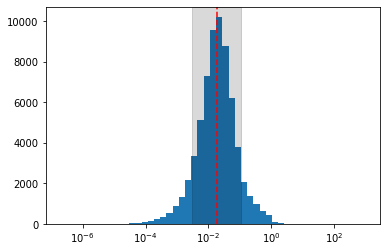

<Figure size 432x288 with 0 Axes>

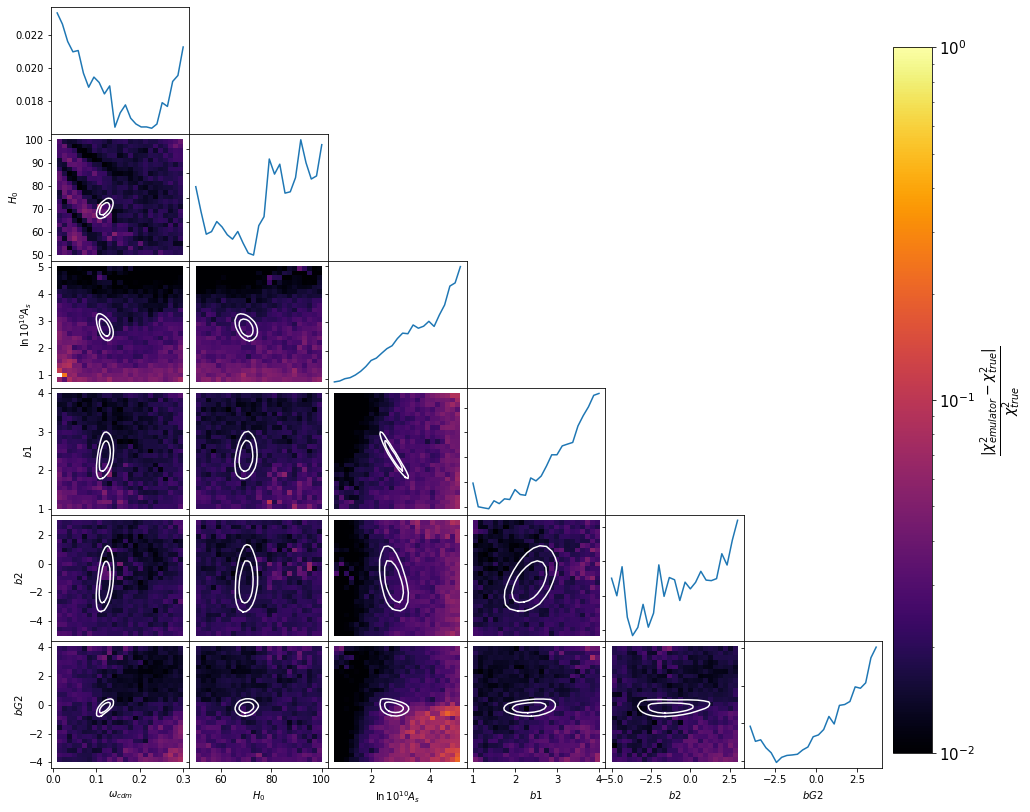

In [17]:
data = np.load("../Data/chi2_test.npz")
chi2_true_1 = data["chi2_true"]
chi2_pred_1 = data["chi2_pred"]

#np.testing.assert_equal(chi2_true, chi2_true_1)

#chi2_error = abs(chi2_pred - chi2_true) / chi2_true
chi2_error = abs(chi2_pred_1 - chi2_true_1) / chi2_true_1

idx = np.where(abs(chi2_error) < 1e2)
num_bad = len(test_data) - len(idx[0])
print("{:0.0f} ({:0.3f}% matrices have huge errors! removing for visualization...".format(num_bad, 100*num_bad / len(test_data)))

params = test_data[:][0].detach().numpy().copy()
params[:,2]*=3.0447

#params = params[idx[0],:]
#chi2_error_cut = chi2_error[idx]
chi2_error_cut = chi2_error
#params = params[(cond_predict < 1e9)]

log_mean = np.mean(np.log10(chi2_error_cut))
log_sigma = np.std(np.log10(chi2_error_cut))
sigma_lo = log_mean - log_sigma
sigma_hi = log_mean + log_sigma

plt.figure()
plt.hist(chi2_error_cut, bins=np.logspace(np.log10(np.amin(chi2_error_cut)), 3, 50))
#plt.hist(10**X, bins=np.logspace(np.log10(np.amin(chi2_error_cut)), 3, 50), alpha=0.3)
plt.axvline(10**log_mean, ls="--", c="red")
plt.axvspan(10**sigma_lo, 10**sigma_hi, alpha=0.15, color="black")
#plt.axvline(np.median(chi2_error_cut), ls="--", c="black")
plt.xscale("log")
#plt.hist(np.log(chi2_error_cut), bins=50)

print("global mean = {:0.3f}%, 1 sigma confidence interval = [{:0.3f}%, {:0.3f}%]".format(100*10**log_mean, 100*10**sigma_lo, 100*10**sigma_hi))
#print("25th - 75h percentiles = [{:0.3f}%, {:0.3f}%]".format(

plt.figure()
plot_heatmap(params, abs(chi2_error_cut), r"$\frac{|\chi^2_{emulator} - \chi^2_{true}|}{\chi^2_{true}}$", [1e-2, 1e-0], "inferno", True, False)

## Quantify the average PC error associated with the emulated covariance

In [9]:
# load in the pca object file (Have to make on HPC!)

PC_true = np.zeros((len(test_data), 250))
PC_pred = np.zeros((len(test_data), 250))

with open("../Data/pca-inv.pkl", "rb") as pickle_file:
    load_data = pkl.load(pickle_file)
    pca = load_data[0]

#for i in tqdm(range(len(test_data))):
# for i in tqdm(range(len(test_data))):
#     C_true = test_data.get_full_matrix(i)
#     params = test_data[i][0].detach().numpy()
#     C_pred = Cov_Emulator_T.get_covariance_matrix(params)
    
#     P_true = np.linalg.inv(C_true).flatten().reshape(1, -1)
#     P_pred = np.linalg.inv(C_pred).flatten().reshape(1, -1)
        
#     PC_true[i] = pca.transform(P_true)
#     PC_pred[i] = pca.transform(P_pred)
#np.savez("../Data/PC_inv.npz", PC_true=PC_true, PC_pred=PC_pred)

694216167925.9891
(250,)
Mean error per PC = 6.317%
Median error per PC = 8.451%
[65.93241498 73.40378849 48.22435788 34.78245324 53.92833339 69.84385639
 45.17116191 55.41540777 19.03201475 36.83597135 52.65109318 45.59316164
 42.68921435 44.52731223 51.96292507 41.65020633 46.65970646 39.259881
 43.78448318 41.18929772 41.12598237 52.60673835 50.85310131 41.21030031
 55.31558096 29.73610115 52.96569631 42.77497936 36.46873933 41.0554234
 32.2122598  41.19467948 20.20338187 56.10507695 53.6663777  49.05588391
 50.61712511 25.6815598  38.83640905 39.14275871 65.16415022 34.17186588
 23.68722542 39.87529756 34.15657395 31.62049125 16.75480096 20.50545464
 14.8932315  16.12655094 43.18180219 40.4704973  26.26498729 17.79646254
 16.72237724 23.64669775  9.90335842 42.18477879 38.40834936 34.46047698
 66.46080388 37.45506189 32.07598877 45.69104011 48.21510932 29.38661145
 25.64120336 39.42839487 11.01772894 42.44075916 36.91305006 14.03051567
 32.83415206 27.64857029 54.18202966 11.080219

(0.0, 100.0)

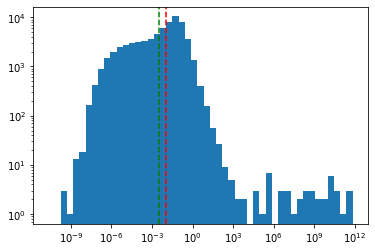

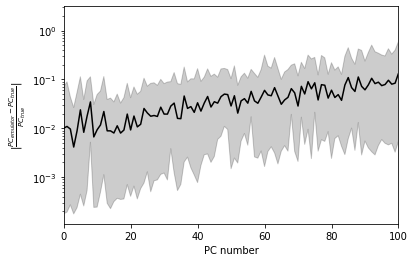

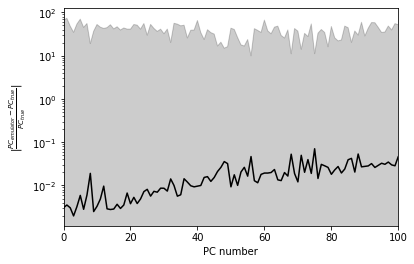

In [99]:
pc_data = np.load("../Data/PC_inv.npz")
# higher PCs are close to 0, so scale by a large number to combat potential floating-point errors
PC_pred = pc_data["PC_pred"] * 1e9
PC_true = pc_data["PC_true"] * 1e9
PC_error = abs((PC_pred - PC_true) / PC_true)
#PC_error = PC_error[(np.mean(PC_error, axis=1) < 1e1),:]

print(np.amax(PC_error[:,0]))
plt.hist(PC_error[:,0], bins=np.logspace(np.log10(np.amin(PC_error[:,0])), np.log10(np.amax(PC_error[:,0])), 50))
plt.axvline(10**np.mean(np.log10(PC_error[:,0])), c="green", ls="--")
plt.axvline(np.median(PC_error[:,0]), c="red", ls="--")
plt.yscale("log")
plt.xscale("log")

median_pc_error = np.median(PC_error, axis=0)
mean_pc_error = np.zeros(PC_error.shape[1])
num_high = np.zeros(PC_error.shape[1])
for i in range(len(avg_pc_error)):
    mean_pc_error[i] = 10**np.mean(np.log10(PC_error[:,i]))
    num_high[i] = len(PC_error[:,i][(PC_error[:,i] > 1e0)])

#print(num_high)

percent_lo = np.percentile(PC_error, 25, axis=0)
percent_hi = np.percentile(PC_error, 75, axis=0)
std = 10**np.std(np.log10(PC_error), axis=0)

error_lo = median_pc_error - percent_lo
error_hi = percent_hi - median_pc_error
print(percent_lo.shape)

print("Mean error per PC = {:0.3f}%".format(100*np.mean(avg_pc_error)))
print("Median error per PC = {:0.3f}%".format(100*np.median(PC_error)))
plt.figure()
plt.plot(median_pc_error, c="black")
plt.fill_between(range(250), percent_lo, percent_hi, alpha=0.2, color="black")
plt.yscale("log")
plt.xlabel("PC number")
plt.ylabel(r"$ \left| \frac{PC_{emulator} - PC_{true}}{PC_{true}} \right|$")
plt.xlim(0, 100)

print(std)
plt.figure()
plt.plot(mean_pc_error, c="black")
plt.fill_between(range(250), mean_pc_error - std, mean_pc_error+std, alpha=0.2, color="black")
plt.yscale("log")
plt.xlabel("PC number")
plt.ylabel(r"$ \left| \frac{PC_{emulator} - PC_{true}}{PC_{true}} \right|$")
plt.xlim(0, 100)

[ 1.26460686e-01 -6.52455635e-02  4.70052593e-02 -4.04671133e-04
 -2.30116961e-01 -3.42025460e-01  4.78996365e-02  9.53991033e-01
 -3.40878024e-01 -4.84783229e-03  1.77632126e-01 -2.92462310e-01
 -6.06456348e-01  4.05285442e-02 -8.34647201e-02  1.84292399e-02
  1.29525896e-01  1.39271113e-02 -5.38479645e-02 -8.66415901e-02
 -3.03422783e-02  1.15004476e-01 -2.85373960e-01 -1.61349010e-01
  1.87243549e-01 -1.86933341e-01 -2.43623790e-01 -5.26545495e-01
 -1.24073753e-01  1.64211460e-01 -3.08191668e-02 -9.64744457e-02
 -2.04806939e-01 -1.27234896e+00  1.93572547e-01 -2.41785288e-01
 -4.62806088e-01 -1.86440727e-03  7.19713699e-02 -1.80445406e-02
  8.32999549e-01 -3.47783400e-01  2.42533577e-01  1.83177583e+00
 -2.76088071e-01 -2.17812442e+00  1.36924378e-01 -1.08056468e-01
  1.26730328e-01  1.94695607e+00  3.61441098e-01 -9.85910728e-01
 -1.10706289e-01 -1.01709513e+00  5.28640321e-02  3.89048666e-02
 -1.00162560e-01 -3.44475651e+00 -6.03545813e-01  8.31195662e+00
  3.50421755e+00  4.22294

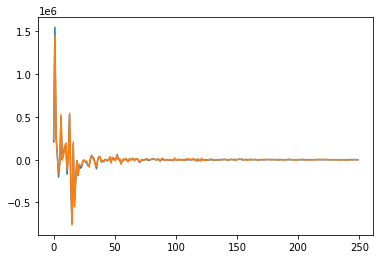

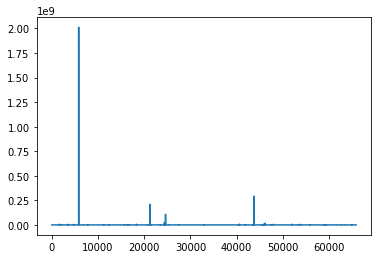

In [158]:
plt.plot(PC_true[100])
plt.plot(PC_pred[100])
#plt.ylim(-1e-4, 1e-4)

pc_error = (PC_pred[100] - PC_true[100]) / PC_true[100]
pc_error_2 = (PC_pred[100,:] - PC_true[100,:])
print(pc_error)
plt.figure()
plt.plot(np.mean(PC_true, axis=1))